# Использование машинного обучения для предсказания цен акций в нефтянной индустрии

Данная статья является кратким пересказом постов из иностранных источников вкупе с моими размышлениями. Анализ будет проводится на основании акций нефтяной отрасли и [цены на нефть марки Brent](https://www.eia.gov/dnav/pet/hist/RBRTED.htm). К сожалению найти откуда скачать бесплатно данные по цене на российскую нефть марки Urals мне не удалось. Сразу предупреждаю, что в данном посте нет попытки показать текущую ситуацию и предсказать дальнейшее направление цены. Так же в данной статье не стоит цель вознести или опорочить использование машинного обучения для анализа цены акций. В анализе будет приведены некоторые из методов по визуалиазиции данных. Для предсказания в краткосрочной перспективе будут использованы линейная регрессия, кластерный анализ и случайный лес.

In [1]:
#Загружаю библиотеки

import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 1. Загрузка данных

In [2]:
xls_file=pd.ExcelFile("./input/RBRTEd.xls") # Прочитать Excel
brent=xls_file.parse("Data 1") # Использовать Data 1
brent.columns=brent.iloc[1] # установить первую строчку как имена колонок
brent=brent.iloc[2:] # удалить второю строчку
brent["Date"]=brent["Date"].astype('datetime64[ns]') # конвертировать первую колонку в формат даты
brent.columns=["Date","oil_price"]
brent.head()

,Date,oil_price
2,1987-05-20,18.63
3,1987-05-21,18.45
4,1987-05-22,18.55
5,1987-05-25,18.6
6,1987-05-26,18.63


Сравниваться котировки на нефть будут с ценами на акции российских компаний относящихся к нефтяной отрасли:
* Роснефть
* Лукойл	
* Сургутнефтегаз	
* Газпром нефть		
* Татнефть	
* Славнефть				
* Башнефть

In [3]:
shares=["ROSN.ME", "LKOH.ME","SNGS.ME","SIBN.ME","TATN.ME","BANE.ME"]

In [18]:
data= yf.download(shares)['Adj Close']

[*********************100%***********************]  6 of 6 completed


In [19]:
# удалим индекс и сделаем новую колонку с датой
data = data.reset_index()

In [20]:
all_data=pd.DataFrame() # создам массив, который будет хранить все данные по акциям и цене на нефть

In [21]:
for index in range(len(shares)):
    stock=pd.DataFrame()
    # трансформируем данные
    stock=data.loc[:, ("Date",shares[index])]
    stock["Date"]=stock["Date"].astype('datetime64[ns]')
    stock.columns=["Date","share_price"]
    test=pd.DataFrame(brent) 
    output=stock.merge(test,on="Date",how="left") # объединение двух наборов данных
    stock["oil_price"]=output["oil_price"]
    stock['share_price']=pd.to_numeric(stock['share_price'], errors='coerce').dropna(0)
    stock['oil_price']=pd.to_numeric(stock['oil_price'], errors='coerce').dropna(0)
    stock["year"]=pd.to_datetime(stock["Date"]).dt.year # Создать колонку с годами для последующей фильтрации
    stock["name"]=shares[index]
    stock = stock.dropna() # удалить все NAN строчки.
    # Создаем колонку с маштабированной ценой акций
    scaler=MinMaxScaler()
    stock["share_price_scaled"]=scaler.fit_transform(stock["share_price"].to_frame())
    # Добавить данные в основной датафрейм
    all_data=all_data.append(stock) #append data to one matri

In [22]:
all_data.head()

,Date,share_price,oil_price,year,name,share_price_scaled
0,2010-03-03,167.156967,78.66,2010,ROSN.ME,0.114304
1,2010-03-04,167.262177,77.88,2010,ROSN.ME,0.114596
2,2010-03-05,170.726639,79.20,2010,ROSN.ME,0.124215
3,2010-03-09,168.159851,78.77,2010,ROSN.ME,0.117089
4,2010-03-10,166.560867,80.29,2010,ROSN.ME,0.112649


In [23]:
# оставляю данные только с 2015 по 2019
all_data_15 = all_data[(all_data['year']>2014)&(all_data['year']<2020)]

## 2. Анализ данных

Анализ данных акций обычно лучше начинать с их визуального представления, что поможет Вам лучше их понять.

### 2.1 График изменение цены на нефть

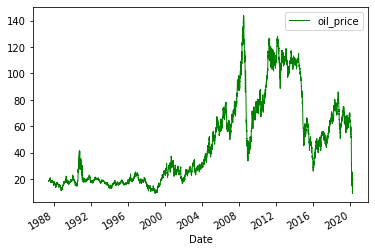

In [70]:
brent[['Date','oil_price']].set_index('Date').plot(color="green", linewidth=1.0)
plt.show()

### 2.2. Построение графика pairplot для цены акции Роснефти за последние пять лет

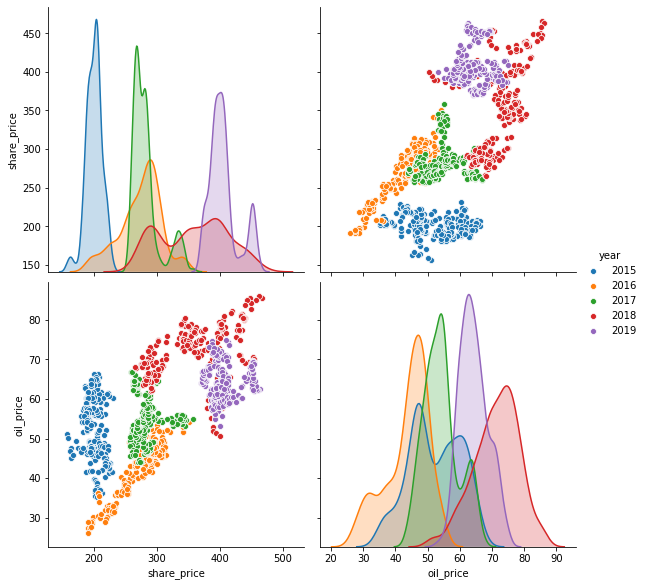

In [119]:
palette=sns.cubehelix_palette(18, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.pairplot(all_data[(all_data['name']=="ROSN.ME")&(all_data['year']>2014)&(all_data['year']<2020)].\
             drop(["share_price_scaled"],axis=1), hue="year",height=4)
plt.show()

Парный график позволяет визуализировать попарное взаимоотношение, а так же одновременно позволяет увидеть  распределение данных. показывает все парные отношения в наборе данных и одномерное распределение данных для каждой переменной. Так же за счет палитры можно посмотреть как эти данные менялись в различные года. 

В построенном графике особый интерес представляют за 2016 год, так как похоже что цена акции Роснефть и цена на нефть выстроились вдоль одной линии. Так же можно сделать заключение благодоря графикам распределения, что цена на нефть колебалась между 40 и 80 долларами, а цена на акцию от 200 до 400. 

### 2.3 Violinplot для цены на нефть

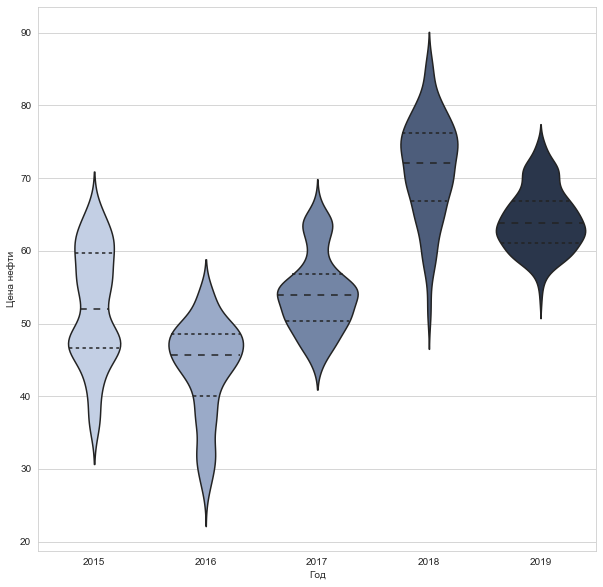

In [129]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
palette=sns.cubehelix_palette(5, start=2.8, rot=0, dark=0.2, light=0.8, reverse=False)

sns.violinplot(x="year", y="oil_price", data=all_data_15[all_data_15['name']=="ROSN.ME"],
               inner="quart", palette=palette, trim=True)
plt.xlabel("Год")
plt.ylabel("Цена нефти")
plt.show()

### 2.4 Violinplot для нескольких акций

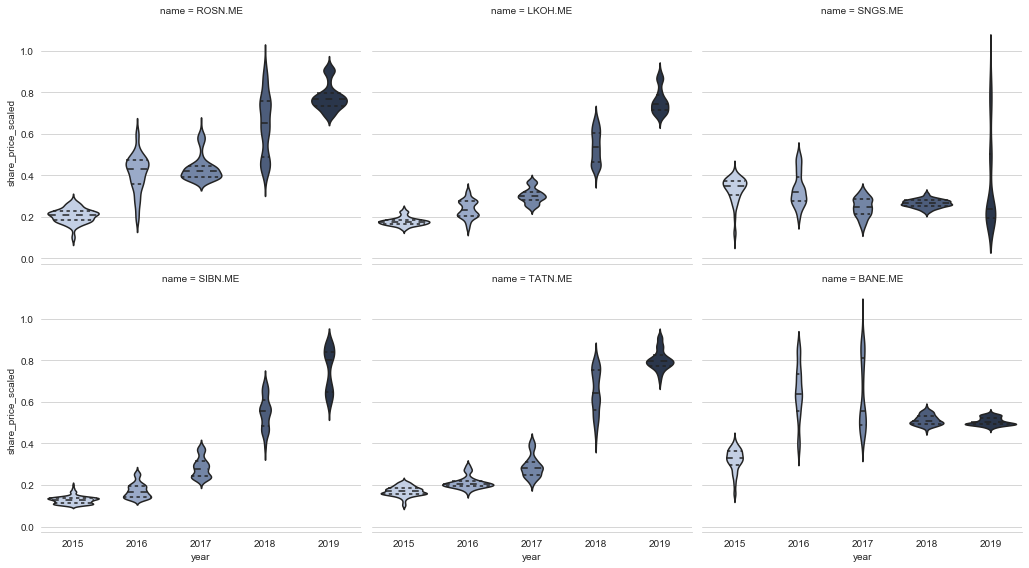

In [132]:
sns.catplot(x="year", y="share_price_scaled", col='name', col_wrap=3,kind="violin",
               split=True, data=all_data_15,inner="quart", palette=palette, trim=True, height=4, aspect=1.2)
sns.despine(left=True)

Большое колебание цен на нефть было отмечено согласно графикам в 2015 и 2018 году.Однако изменчивость в диапазоне цен на акции и распределении для разных компаний могла не совпадать. Несколько компаний были более чувствительными, чем другие. Так же необходимо отметить, что все цены отмаштабированы в диапазоне от 0 до 1 и это может приводить к ошибкам в интерпритации.

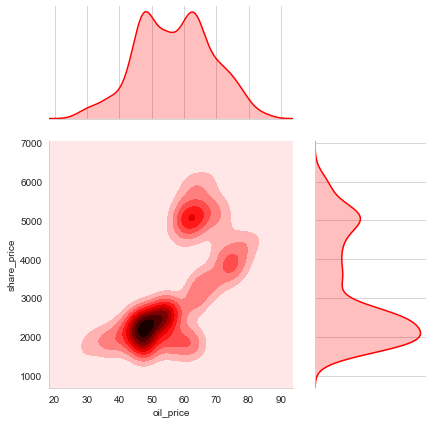

In [136]:
sns.jointplot("oil_price", "share_price",data=all_data_15[all_data_15['name']=="LKOH.ME"],kind="kde",
              height=6,ratio=2,color="red").plot_joint(sns.kdeplot, zorder=0, n_levels=20)
plt.show()

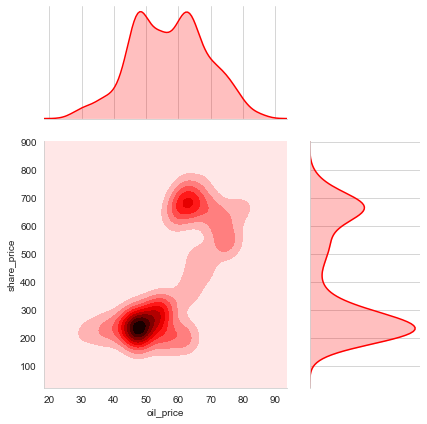

In [138]:
sns.jointplot("oil_price", "share_price",data=all_data_15[all_data_15['name']=="TATN.ME"],kind="kde",
              height=6,ratio=2,color="red").plot_joint(sns.kdeplot, zorder=0, n_levels=20)
plt.show()

Необходимо обратить внимание на распределение цены акций для двух компаний и станет видно, что форма графика плотностей у них совпадает.

### 2.5 График зависимости цены акций различных компаний цены нефти 

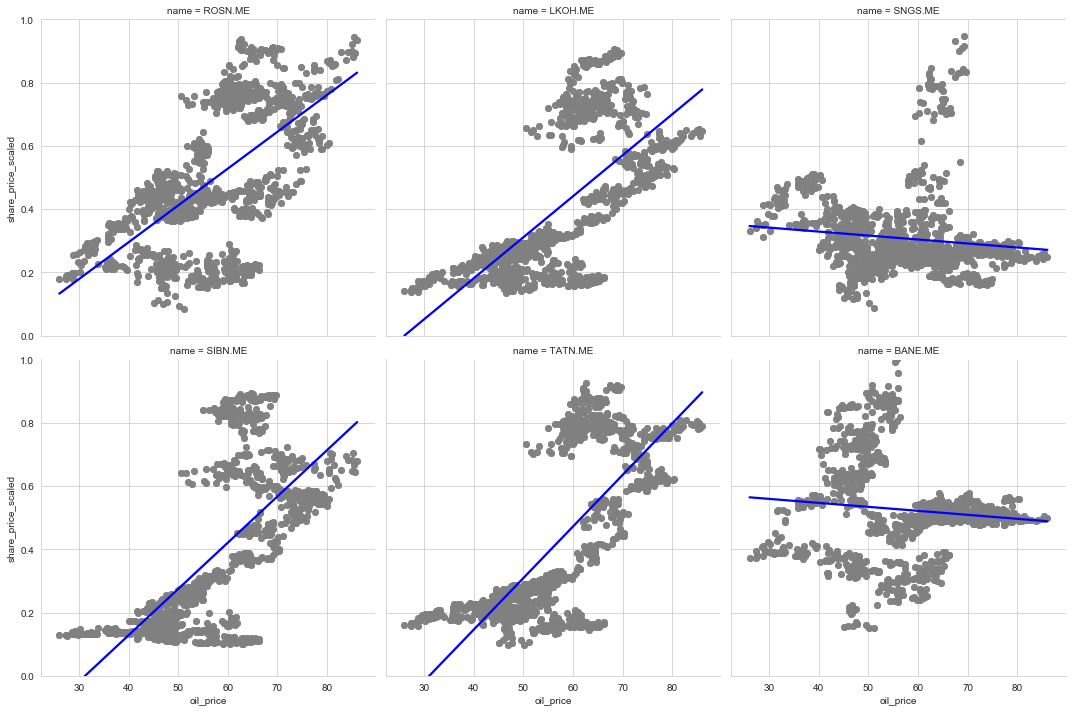

In [141]:
sns.lmplot(x="oil_price", y="share_price_scaled", col="name",ci=None, col_wrap=3, 
           data=all_data_15, order=1,line_kws={'color': 'blue'},scatter_kws={'color': 'grey'}).set(ylim=(0, 1))
plt.show()

На самом деле много не удасться увидеть на этих графииках, хотя у некоторых акций похоже прослеживается зависимость.

Следующим шагом можно попытаться раскрасить графики в зависимости от годов.

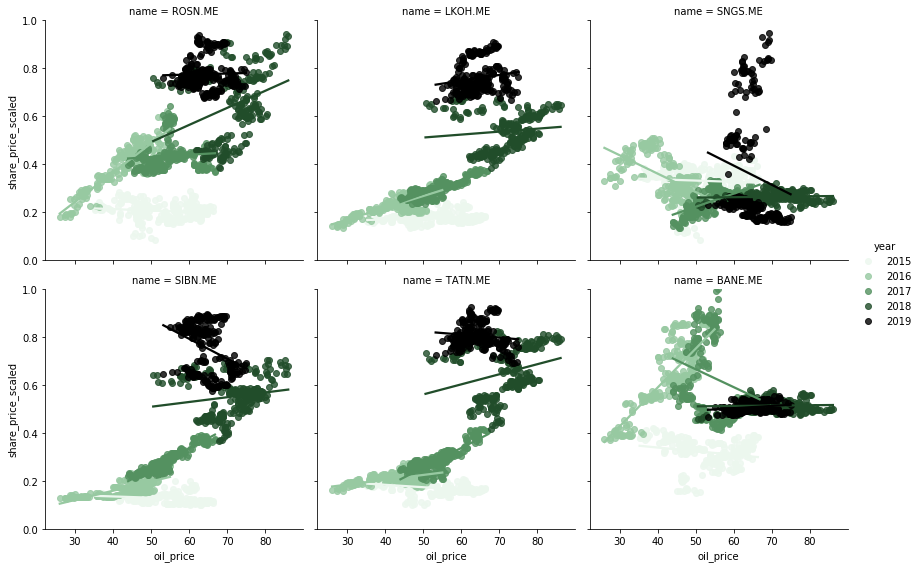

In [20]:
palette=sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.lmplot(x="oil_price", y="share_price_scaled",hue="year", col="name",ci=None, 
           col_wrap=3, data=all_data_15, order=1,palette=palette,height=4).set(ylim=(0, 1))
plt.show()

Тут картинка немного лучше в том плане, что у некоторых компаний наблюдается вытягивание облака данных вдоль прямой в некоторые года, что может указывать на существование зависимости.

# 3 Машинное обучение и предсказание

По сути, машинное обучение - это подобласть искусственного интеллекта. Data driven подход полагающийся на выучивание закономерностей из имеющихся размеченных или неразмеченных данных. Идея в том, чтобы не програмировать алгоритм решения задачи вручную, а выучить его из данных (Григорий Сапунов. Введение в машинное обучение). Обычно алгоритмы машинного обучения можно отнести к следущим категориям: обучение с учителем и обучение без учителя. Приведем их определение с одного из сайтов:

Обучение с учителем (Supervised learning) — один из разделов машинного обучения, посвященный решению следующей задачи. Имеется множество объектов (ситуаций) и множество возможных ответов (откликов, реакций). Существует некоторая зависимость между ответами и объектами, но она неизвестна. Известна только конечная совокупность прецедентов — пар «объект, ответ», называемая обучающей выборкой. На основе этих данных требуется восстановить зависимость, то есть построить алгоритм, способный для любого объекта выдать достаточно точный ответ. Для измерения точности ответов определённым образом вводится функционал качества. см. [Ссылки](http://www.machinelearning.ru/wiki/index.php?title=%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81_%D1%83%D1%87%D0%B8%D1%82%D0%B5%D0%BB%D0%B5%D0%BC)) 

Обучение без учителя (Unsupervised learning) — один из разделов машинного обучения. Изучает широкий класс задач обработки данных, в которых известны только описания множества объектов (обучающей выборки), и требуется обнаружить внутренние взаимосвязи, зависимости, закономерности, существующие между объектами. Обучение без учителя часто противопоставляется обучению с учителем, когда для каждого обучающего объекта задаётся «правильный ответ», и требуется найти зависимость между объектами и ответами. см. [Ссылки](http://www.machinelearning.ru/wiki/index.php?title=%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B1%D0%B5%D0%B7_%D1%83%D1%87%D0%B8%D1%82%D0%B5%D0%BB%D1%8F))  

Дальше при помощи кластерного анализа будут рассмотрены следующие методы машинного обучения:
* Кластерный анализ 
* Линейная регрессия 
* Случайный лес 

При помощи данных алгоритмов можно оценить переоценены или недооценены акции относительно цены на нефть. Как я говорил раньше, в этой статье данная задача не стоит. Основная ее цель - показать потенциал машинного обучения для оценки акций. 

### 3.1. Кластерный анализ для акций Роснефти

Дальше разделим данные по Роснефти на 6 групп, используя кластерный анализ.  Кластеризация - это задача разбиения множества объектов на группы, называемые кластерами. Внутри каждой группы должны оказаться «похожие» объекты, а объекты разных группы должны быть как можно более отличны. см. [Ссылки](https://habr.com/ru/post/101338/).

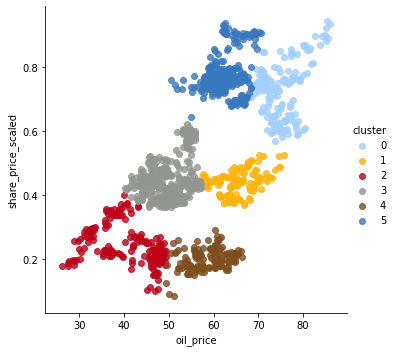

In [59]:
from sklearn.cluster import KMeans

rosn=all_data_15[all_data_15['name']=="ROSN.ME"]
# We need to scale also oil price, so clustering is not influenced by the relative size of one axis.
rosn=pd.DataFrame(rosn)
rosn['oil_price_scaled'] = scaler.fit_transform(rosn["oil_price"].to_frame())
rosn["cluster"] = KMeans(n_clusters=6, random_state=1).fit_predict(rosn[["share_price_scaled","oil_price_scaled"]])

# The 954 most common RGB monitor colors https://xkcd.com/color/rgb/
colors = ["baby blue", "amber", "scarlet", "grey","milk chocolate", "windows blue"]
palette=sns.xkcd_palette(colors)

sns.lmplot(x="oil_price", y="share_price_scaled",ci=None,palette=palette, hue="cluster",fit_reg=0 ,data=rosn)

plt.show()

Кластерный анализ используется в большом количестве задач, но в нашем случае он был рассмотрен только в качестве группировки данных и для наглдной визуализации кластерного анализа.

### 3.2. Линейная регрессия между акциями Татнефть и ценой на нефть

Далее построим обычную линейную регрессию при помощи обучения с учителем. Цель состоит в том, чтобы оценить прогноз данных за последние 100 дней 2019 года на основании данных 2018/2019 годов (без учета оцениваемых). Тренировочные данные - это данные, используемые для построения модели, а тестовые данные - те, которые попытаемся предсказать.

In [64]:
from sklearn import linear_model

# Подготовка данных
lkoh_18=pd.DataFrame()
lkoh_18=all_data_15[(all_data_15['name']=="BANE.ME") & (all_data_15['year']>2017 )] # Взять данные 2018/19
lkoh_18=lkoh_18[["share_price","oil_price"]].reset_index()

In [65]:
# Для построения будет использована только одна переменная. Для большего числа будет использована модель RandomForest
# Разделим данные на обучающие и тестовые
train = lkoh_18[:-100]
test = lkoh_18[-100:]

x_train=train["oil_price"].to_frame() # преобразовать Series в numpy.ndarray
y_train=train['share_price'].to_frame()
x_test=test["oil_price"].to_frame() # преобразовать Series в numpy.ndarray
y_test=test['share_price'].to_frame()

In [66]:
# Построение модели линейной регрессии и ее тренировка
regr = linear_model.LinearRegression()
regr.fit(x_train,y_train)

# Узнать коэффициент
print("Coefficients: ",  float(regr.coef_))
# Узнать среднеквадратичную ошибку
print("Mean squared error: %.2f"
      % np.mean((regr.predict(x_train) - y_train) ** 2))

Coefficients:  1.8068503676257566
Mean squared error: 4194.19


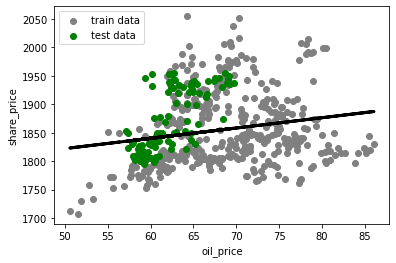

In [67]:
# Plot outputs using matplotlib
plt_train=plt.scatter(x_train, y_train,  color='grey')
plt_test=plt.scatter(x_test, y_test,  color='green')
plt.plot(x_train, regr.predict(x_train), color='black', linewidth=3)
plt.plot(x_test,regr.predict(x_test),  color='black', linewidth=3)
plt.xlabel("oil_price")
plt.ylabel("share_price")
plt.legend((plt_train, plt_test),("train data", "test data"))
plt.show()

На построенном выше рисунке можно увидеть попытку предсказать данные по акциям Татнефть на основании модели линейной регрессии. Похоже, что она не подходит для этой цели. Среднеквадратичная ошибка этого метода прогнозирования составляет 6290.69. Далее посмотрим алгоритм случайного леса.

### 3.3 Случайный лес на акциях Royal Dutch Shell против цены на нефть

Отдельно расписывать об алгоритме случайного леса 